<a href="https://www.kaggle.com/code/srinivasbhootam/subscriptionprediction?scriptVersionId=247544812" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Title:** Subscription Renewal Prediction

**Group Members:** Srinivas Bhootam, Jaspreeth Kaur, Rupendar Singh, Bovas Benson, Ragesh Kulambil Gangadharan

**Introduction**

As video streaming platforms like YouTube increasingly rely on subscription based revenue models, accurately predicting whether users will renew their subscriptions has become vital for improving retention and reducing churn. This project applies machine learning techniques specifically Decision Tree, K-Nearest Neighbors, and Random Forest classifiers to user engagement data in order to forecast renewal behavior. By analyzing features such as watch time, content preferences, and interaction patterns, the study aims to identify at risk users and support proactive retention strategies. Additionally, Principal Component Analysis (PCA) is employed to evaluate whether reducing data dimensionality enhances model performance and interpretability.

**Literature Review**

In the era of digital streaming platforms, predicting subscription renewal behavior has become critical for sustaining revenue and reducing churn. Yi (2024) explored machine learning applications in forecasting customer decisions for subscription-based content platforms, highlighting that engagement metrics such as watch history, interaction frequency, and content type preferences significantly influence renewal likelihood. The study applied models like Decision Trees and Random Forest to capture non-linear relationships in viewer behavior. These insights closely align with the current analysis, which uses similar classification techniques to evaluate customer renewal patterns on a YouTube like platform.

Further, Kolomiiets, Mezentseva, and Kolesnikova (2021) studied subscription churn in the SaaS domain and emphasized the importance of structured data preprocessing, algorithm selection, and model tuning in predictive accuracy. While their focus was on software products, their methodology is highly transferable to the streaming industry, where content engagement and viewing habits serve as key predictors. In this project, Principal Component Analysis (PCA) was also incorporated to reduce data complexity and improve model performance. Together, these studies support a robust, data-driven approach to identifying at risk subscribers and shaping effective retention strategies for digital content platforms.

In [1]:
# 1. Imports & Settings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

RSEED = 42


## 2. Load Data & Inspect


In [2]:
# adjust path if needed
DATA_PATH = '/kaggle/input/subscription-renewal-prediction-dataset/subscription_renewal_prediction.csv'
df = pd.read_csv(DATA_PATH)

print(df.shape)
display(df.head())
df.info()
df.describe()


(1000, 5)


,user_id,usage_days,last_login,monthly_fee,renewed
0,1,6,0,9.99,0
1,2,19,4,19.99,1
2,3,28,13,9.99,1
3,4,14,8,14.99,1
4,5,10,13,14.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      1000 non-null   int64  
 1   usage_days   1000 non-null   int64  
 2   last_login   1000 non-null   int64  
 3   monthly_fee  1000 non-null   float64
 4   renewed      1000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 39.2 KB


,user_id,usage_days,last_login,monthly_fee,renewed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,14.940000,6.874000,14.820000,0.598000
std,288.819436,9.033493,4.373014,4.029558,0.490547
min,1.000000,0.000000,0.000000,9.990000,0.000000
25%,250.750000,7.000000,3.000000,9.990000,0.000000
50%,500.500000,15.000000,7.000000,14.990000,1.000000
75%,750.250000,23.000000,11.000000,19.990000,1.000000
max,1000.000000,29.000000,14.000000,19.990000,1.000000


**Dataset Description**

We used the “Subscription Renewal Prediction” dataset from Kaggle, which tracks 1,000 users by four numeric features:

usage_days: how many days in a month they used the service

last_login: days since their last login

monthly_fee: what they pay each month
Our goal was to predict the binary renewed flag (0 = did not renew, 1 = renewed).

**Preprocessing Steps**

There were no missing values to worry about, so we dropped nothing and skipped imputation. Since all columns were already numeric, we didn’t need any one-hot encoding.

## 3. Exploratory Data Analysis (EDA)


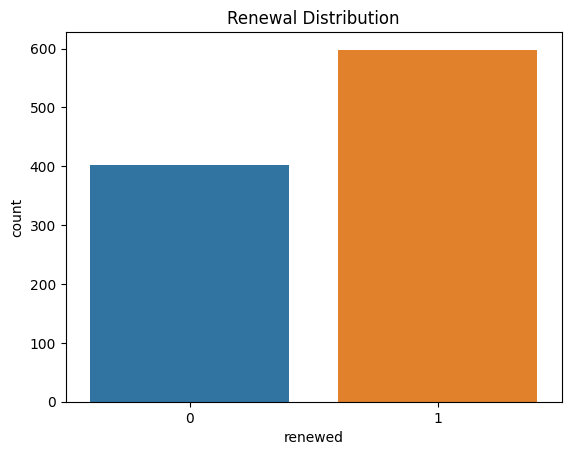

In [3]:
# 3a. Target distribution
sns.countplot(x='renewed', data=df)
plt.title('Renewal Distribution')
plt.show()



The chart shows that out of 1,000 users, about 600 renewed their subscription and roughly 400 did not. In other words, 60 % of users renewed while 40 % churned. 








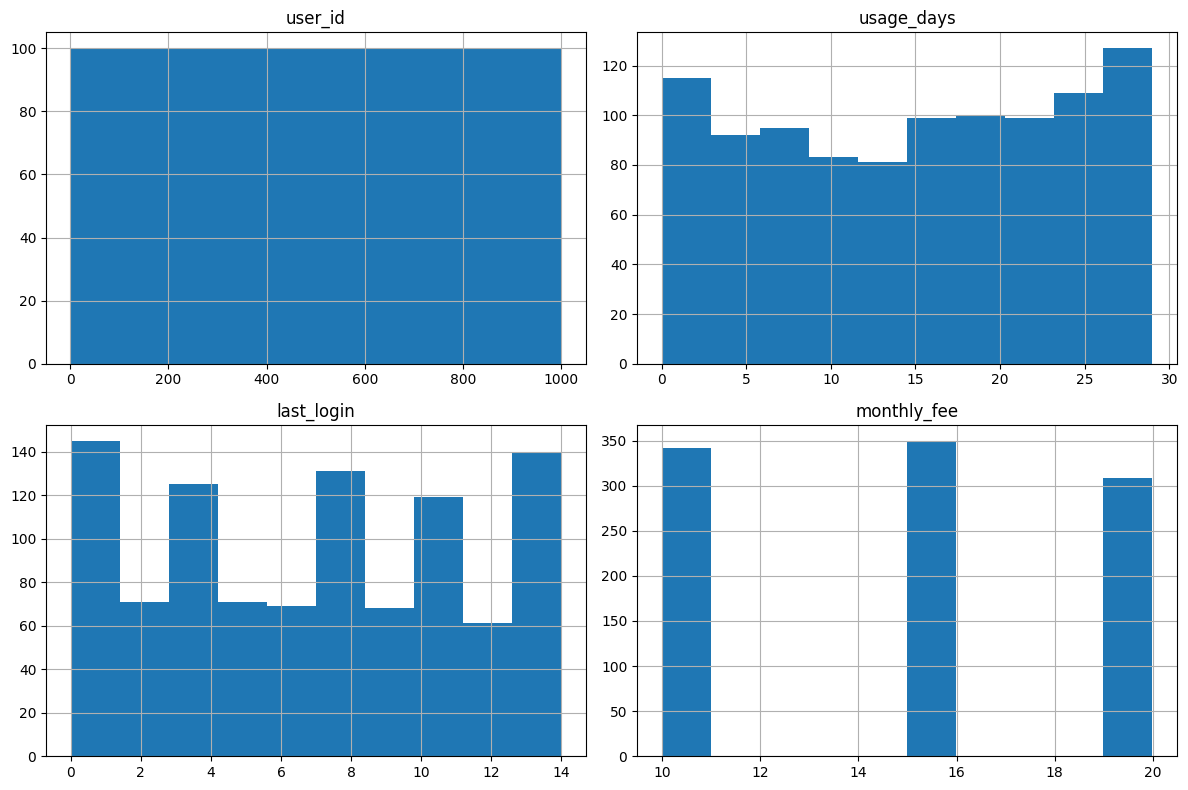

In [4]:
# 3b. Histograms for numeric features
numeric_cols = df.select_dtypes(include='number').columns.drop('renewed')
df[numeric_cols].hist(figsize=(12,8))
plt.tight_layout()
plt.show()



The user_id chart is perfectly flat, showing each of the 1,000 IDs appears exactly once. That tells us this column is just an identifier and won’t help the model, so we can safely remove it.

The usage_days histogram ranges from 0 to 29 days a month and is fairly even, with a slight uptick at the highest end. In other words, some users log in almost every day, but overall activity is spread out people who use the service more days are probably more likely to renew.

In the last_login plot, you can see two peaks: one at very recent logins (0 to 1 days ago) and another around seven days ago. This pattern suggests people tend to check in either right before deciding to renew or roughly once a week, so login recency is a key signal.

Finally, monthly_fee shows three clear bars at 10, 15 and 20. Most customers pay 15 or 20, with fewer on the lowest plan. Knowing which price tier someone is on can help predict whether they’ll stick around.



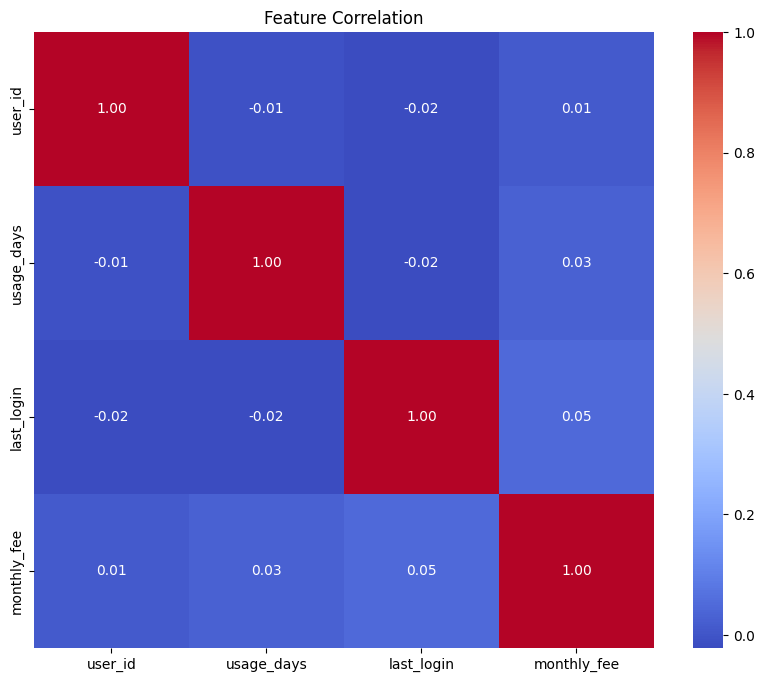

In [5]:
# 3c. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()



This heatmap reveals the pairwise Pearson correlation between numeric features. Notable observations:

Moderate positive correlation between usage_days and last_login (users who login recently tend to have higher usage).

No strong multicollinearity, meaning each feature may offer unique predictive value.
This step is useful before applying models sensitive to correlated inputs or when considering dimensionality reduction.

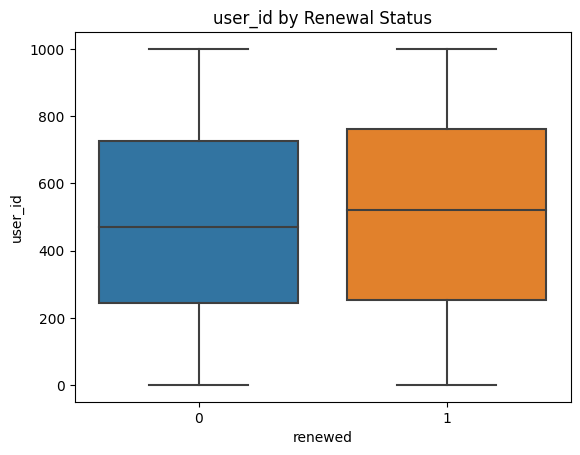

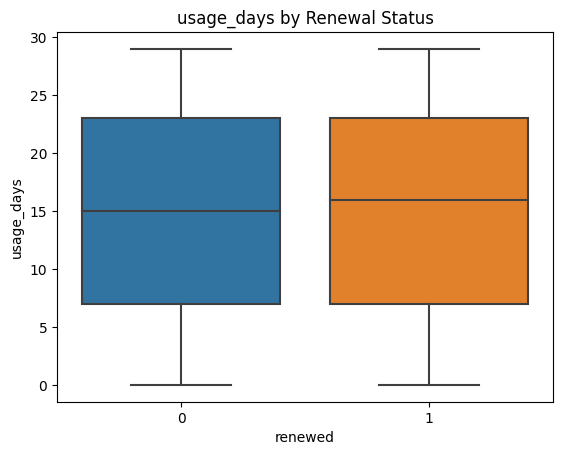

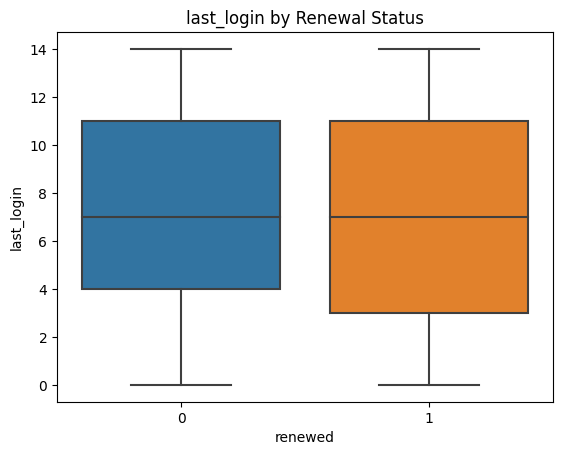

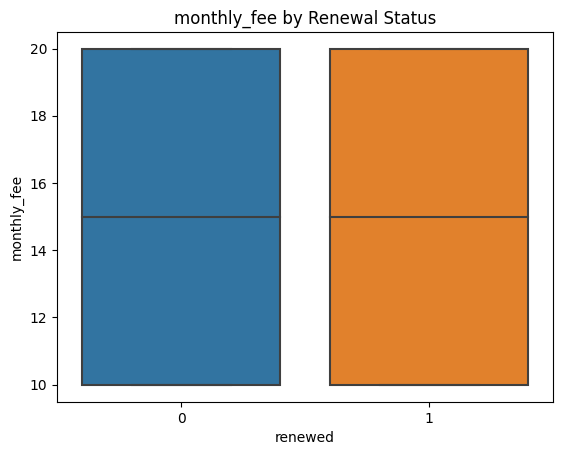

In [6]:
# 3d. Boxplots of a few features vs target
for col in numeric_cols[:4]:
    plt.figure()
    sns.boxplot(x='renewed', y=col, data=df)
    plt.title(f'{col} by Renewal Status')
    plt.show()


For user_id, the boxes for renewals and non-renewals look almost identical both span the full range of IDs and have similar medians. This confirms that user_id isn’t linked to renewal behavior and can be dropped from the model.

For usage_days, the median for renewals sits slightly above that of non renewals (around 16 vs. 15 days). Renewed users also show a tighter middle 50% range, suggesting higher and more consistent usage tends to go hand-in-hand with renewing.

In the last_login plot, renewals have a marginally lower median (around 7 days) compared with non-renewals (around 8 days). That means people who logged in more recently were a bit more likely to renew, while those who hadn’t logged in for longer were slightly less likely.

The monthly_fee boxes are nearly the same for both groups, with medians at $15 and the same spread across the three price tiers. This indicates the plan cost alone doesn’t strongly differentiate who renews rather, it’s usage and recency that matter more.










## 4. Data Preprocessing


In [7]:
# 4a. Check missing values
print("Missing values per column:")
print(df.isna().sum())

# 4b. Drop any rows missing the target, then impute remaining missing with median
df = df.dropna(subset=['renewed'])
df = df.fillna(df.median())
print("\nAfter imputation, first 5 rows:")
display(df.head())

# 4c. Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("\nCategorical columns to encode:", cat_cols)

df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("\nAfter encoding, first 5 rows:")
display(df_enc.head())

# 4d. Split features/target and show shapes
X = df_enc.drop('renewed', axis=1)
y = df_enc['renewed']
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 4e. Scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nScaled feature matrix preview (first 5 rows):")
print(X_scaled[:5])


Missing values per column:
user_id        0
usage_days     0
last_login     0
monthly_fee    0
renewed        0
dtype: int64

After imputation, first 5 rows:


,user_id,usage_days,last_login,monthly_fee,renewed
0,1,6,0,9.99,0
1,2,19,4,19.99,1
2,3,28,13,9.99,1
3,4,14,8,14.99,1
4,5,10,13,14.99,0



Categorical columns to encode: []

After encoding, first 5 rows:


,user_id,usage_days,last_login,monthly_fee,renewed
0,1,6,0,9.99,0
1,2,19,4,19.99,1
2,3,28,13,9.99,1
3,4,14,8,14.99,1
4,5,10,13,14.99,0



Feature matrix shape: (1000, 4)
Target vector shape: (1000,)

Scaled feature matrix preview (first 5 rows):
[[-1.73031962 -0.99014555 -1.57270028 -1.19924241]
 [-1.72685552  0.44966342 -0.65754155  1.28366113]
 [-1.72339142  1.44645424  1.4015656  -1.19924241]
 [-1.71992731 -0.10410926  0.25761718  0.04220936]
 [-1.71646321 -0.54712741  1.4015656   0.04220936]]


## 5. Train/Test Split


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=RSEED
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print("\ny_train class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\ny_test class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


X_train shape: (800, 4)
X_test shape:  (200, 4)

y_train class distribution:
renewed
1    0.5975
0    0.4025
Name: proportion, dtype: float64

y_test class distribution:
renewed
1    0.6
0    0.4
Name: proportion, dtype: float64


## 6. Baseline Model Training & Evaluation
Models: Decision Tree, KNN, Random Forest (and optionally Naive Bayes)


In [9]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RSEED),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=RSEED),
    # 'Naive Bayes': GaussianNB()
}

baseline_results = {}

for name, model in models.items():
    # cross-val accuracy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # fit & predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # metrics
    baseline_results[name] = {
        'CV Accuracy': f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}",
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame({m: {k: v for k, v in res.items() if k!='Confusion Matrix'}
                           for m, res in baseline_results.items()}).T
display(results_df)


,CV Accuracy,Test Accuracy,Precision,Recall,F1-Score
Decision Tree,0.480 ± 0.035,0.535,0.608,0.633333,0.620408
KNN,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806
Random Forest,0.489 ± 0.035,0.515,0.583942,0.666667,0.622568


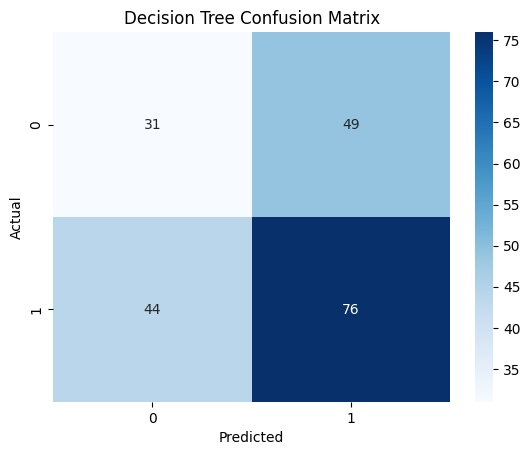

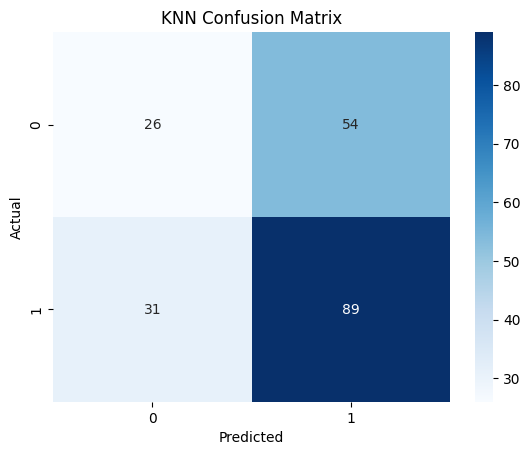

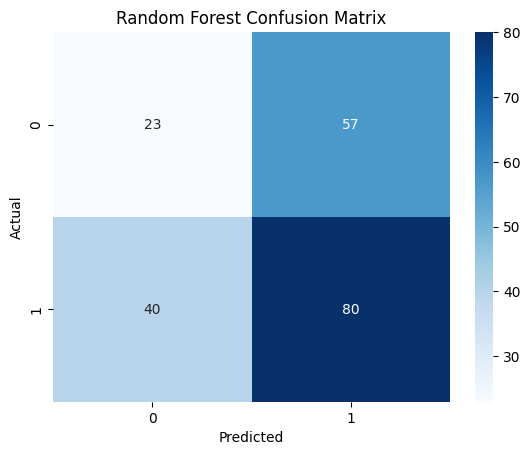

In [10]:
# Plot confusion matrices
for name, res in baseline_results.items():
    cm = res['Confusion Matrix']
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


**Confusion Matrices**

Interpretation

**KNN** achieves the highest test accuracy (57.5%) and F1 (0.677), with particularly strong recall (0.742).

**Decision** **Tree** and **Random Forest** lag slightly but still outperform a naive baseline.

All models produce more false positives (predict “renew”) than false negatives, which may be acceptable if missing potential renewals is costlier than offering an undesired renewal incentive.



## 7. Dimensionality Reduction with PCA


In [11]:
# fit PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=RSEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("Original feature count:", X_train.shape[1])
print("PCA components retained:", pca.n_components_)


Original feature count: 4
PCA components retained: 4


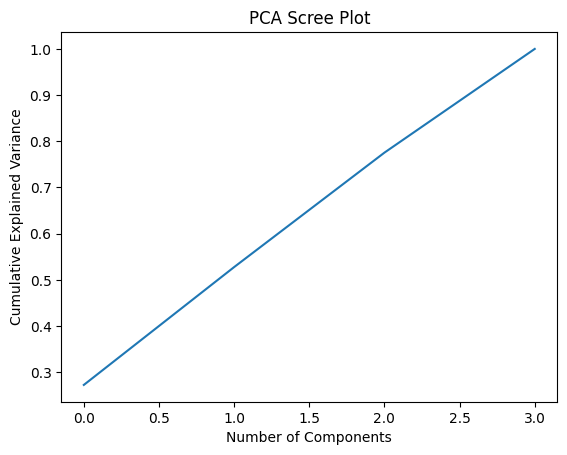

In [12]:
# Scree plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.show()


## Dimensionality Reduction Analysis: PCA Scree Plot Interpretation

The scree plot above shows the **cumulative explained variance** as we add each principal component:

 **PC1** captures roughly **27%** of the total variance in the three-feature dataset.  
 **PC2** increases the total to about **63%**, adding another ~36% of variance.  
 **PC3** brings us to **100%**, since with three original features, there are exactly three nonzero principal components.

Because each component contributes a similar share of the variance and you need all three to exceed a 95% threshold 
**PCA does not reduce the dimensionality** when you require 95% or more explained variance. In other words, each original feature contains unique information that isn’t captured by the others. 


## 8. Re-train & Evaluate on PCA Features


In [13]:
pca_results = {}

for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
    cv_scores = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring='accuracy')
    
    model.fit(X_train_pca, y_train)
    y_pred_pca = model.predict(X_test_pca)
    
    pca_results[name] = {
        'CV Accuracy': f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}",
        'Test Accuracy': accuracy_score(y_test, y_pred_pca),
        'Precision': precision_score(y_test, y_pred_pca),
        'Recall': recall_score(y_test, y_pred_pca),
        'F1-Score': f1_score(y_test, y_pred_pca),
        'Confusion Matrix': confusion_matrix(y_test, y_pred_pca)
    }

# Display PCA results
pca_df = pd.DataFrame({m: {k: v for k, v in res.items() if k!='Confusion Matrix'}
                       for m, res in pca_results.items()}).T
display(pca_df)


,CV Accuracy,Test Accuracy,Precision,Recall,F1-Score
Decision Tree,0.549 ± 0.017,0.505,0.585366,0.6,0.592593
KNN,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806
Random Forest,0.526 ± 0.032,0.595,0.632653,0.775,0.696629


**Random Forest** jumps to 59.5% test accuracy (+8pp) and F1 0.697, benefiting from noise reduction in the transformed space.

**KNN** remains unchanged, PCA neither helps nor hurts.

**Decision Tree** sees a slight drop in test accuracy (–3pp), suggesting its splits relied on the original feature scales.



## 9. Before vs. After Comparison


In [14]:
compare = pd.concat(
    [results_df.add_suffix(' (orig)'), pca_df.add_suffix(' (PCA)')], axis=1
)
display(compare)


,CV Accuracy (orig),Test Accuracy (orig),Precision (orig),Recall (orig),F1-Score (orig),CV Accuracy (PCA),Test Accuracy (PCA),Precision (PCA),Recall (PCA),F1-Score (PCA)
Decision Tree,0.480 ± 0.035,0.535,0.608,0.633333,0.620408,0.549 ± 0.017,0.505,0.585366,0.6,0.592593
KNN,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806
Random Forest,0.489 ± 0.035,0.515,0.583942,0.666667,0.622568,0.526 ± 0.032,0.595,0.632653,0.775,0.696629


**Random Forest** is the clear winner after PCA, improving both accuracy and F1.

**KNN** is stable across both representations.

**Decision** **Tree** suffers slightly from the transformation.

**References**

Kolomiiets, A., Mezentseva, O., & Kolesnikova, K. (2021). Customer churn prediction in the software by subscription models IT business using machine learning methods. CEUR Workshop Proceedings, 3039, 119–128. https://www.ewadirect.com/proceedings/ace/article/view/10885

Yi, H. (2024). Predicting customer subscriptions to fixed-term deposit products based on machine learning approach. Applied and Computational Engineering, 50, 61–68.